In [1]:
!pip install -U tensorflow_datasets

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
dataset, metadata = tfds.load("fashion_mnist", as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
class_names = metadata.features["label"].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
num_train_examples = metadata.splits["train"].num_examples
num_test_examples = metadata.splits["test"].num_examples
print("Eğitim veri setimizdeki örnekk sayımız : {}".format(num_train_examples))
print("Test veri setimizdeki örnek sayımız: {}".format(num_test_examples))

Eğitim veri setimizdeki örnekk sayımız : 60000
Test veri setimizdeki örnek sayımız: 10000


In [8]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# map işlevi, normelleştirmeyi eğitim ve test veri setimizdeki her öğeye uygular.
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Veri setini ilk kullandığımızda, görüntüler diskten yüklenecektir.
# Ön belleğe alma, onları bellekte tutacak ve eğitimi daha hızlı hale getirecektir.
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

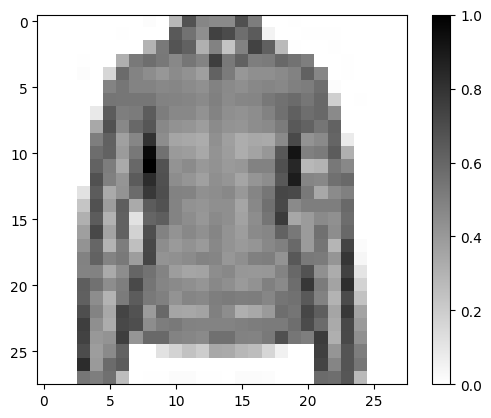

In [9]:
# Tek bir görüntü alır ve yeniden şekillendirir. Renk boyutunu kaldırır.

for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Resmi çizdirme
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

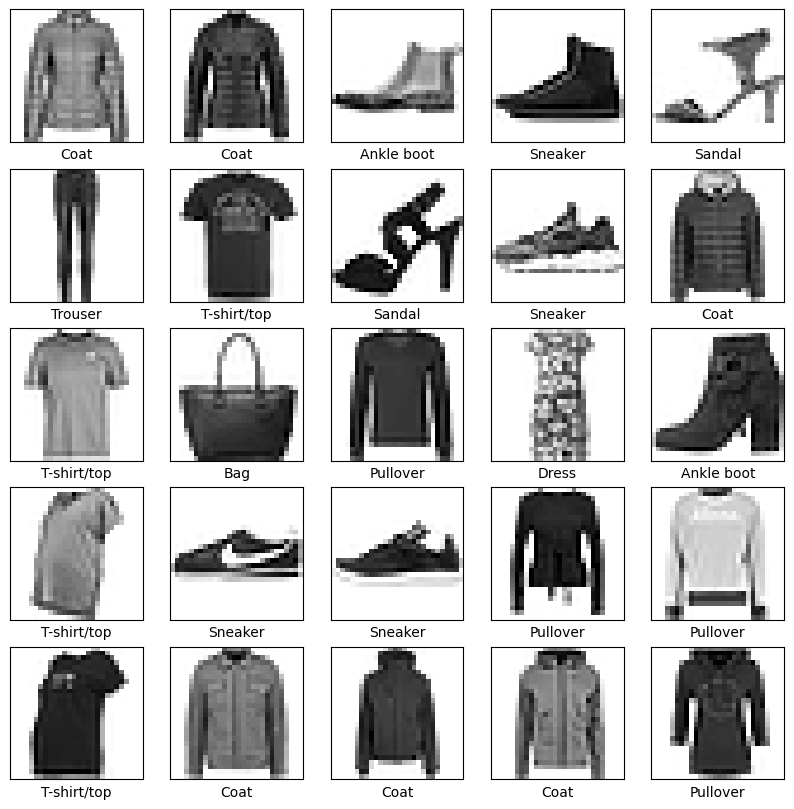

In [10]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(test_dataset.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()

In [11]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)


In [14]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))


Epoch 1/5
1875/1875 [==============================] - 13s 3ms/step - loss: 0.4962 - accuracy: 0.8262
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3704 - accuracy: 0.8664
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3354 - accuracy: 0.8777
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3145 - accuracy: 0.8843
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2944 - accuracy: 0.8917


In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Test veri setinin doğruluk (accuracy) değeri:', test_accuracy)


313/313 [==============================] - 3s 9ms/step - loss: 0.3367 - accuracy: 0.8787
Test veri setinin doğruluk (accuracy) değeri: 0.8787000179290771


In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 86ms/step


In [17]:
predictions.shape

(32, 10)

In [18]:
predictions[0]

array([8.0260354e-05, 2.3171815e-05, 2.9208194e-02, 1.5490310e-06,
       9.4248664e-01, 1.2430840e-11, 2.8188927e-02, 6.6413871e-12,
       1.1220342e-05, 4.9519849e-10], dtype=float32)

In [19]:
np.argmax(predictions[0])

4

In [20]:

test_labels[0]

4

In [21]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

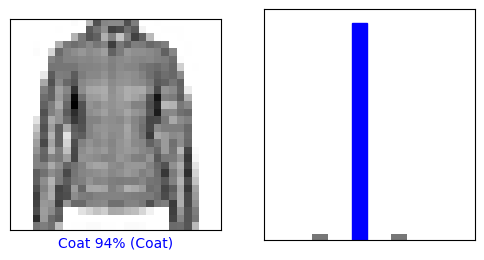

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

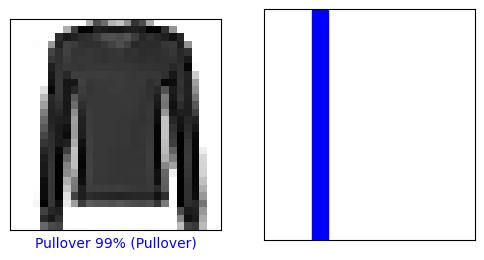

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

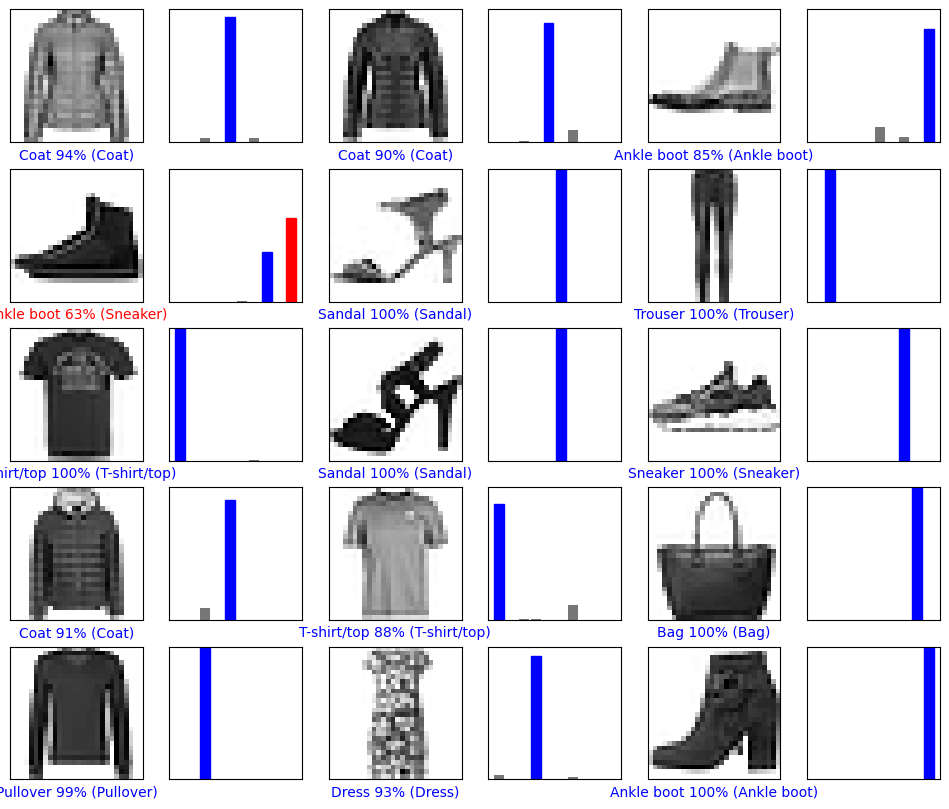

In [24]:

# İlk test görüntülerini, ardından tahmin edilen ve gerçek etiketleri gösterelim.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [25]:

# Test veri kümesinden bir görüntü alalım
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [26]:

# Resmi tek üyenin olduğu bir listeye ekleyelim
img = np.array([img])

print(img.shape)


(1, 28, 28, 1)


In [27]:

predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 86ms/step
[[8.02604991e-05 2.31718568e-05 2.92082448e-02 1.54903387e-06
  9.42486525e-01 1.24308385e-11 2.81889625e-02 6.64138623e-12
  1.12203616e-05 4.95199382e-10]]


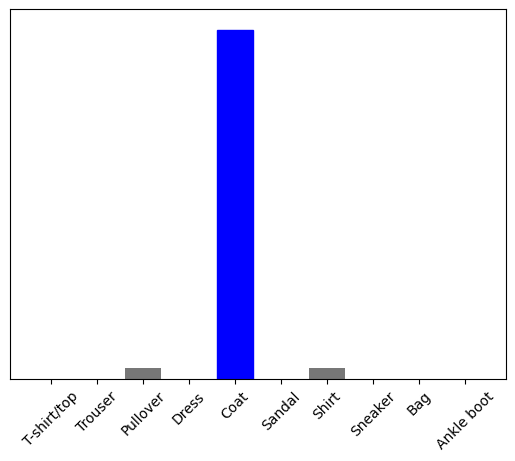

In [28]:

plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [29]:

np.argmax(predictions_single[0])

4